In [68]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, auc
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from itertools import product
from scipy.optimize import fmin
warnings.simplefilter(action='ignore', category=FutureWarning)

In [27]:
def apply_threshold(predict, threshold):
    pred = predict.copy()
    pred = pred[:,1]
    matching = (pred >= threshold)
    pred[matching] = 1
    pred[~matching] = 0
    return pred

def bank_scoring(y_test, predict):
    confu = confusion_matrix(y_test, predict)
    FP = confu[1,0]
    FN = confu[0,1]
    loss_for_bank = 10*FP + FN
    return loss_for_bank

banklosss = make_scorer(bank_scoring, greater_is_better=False)

def scaler(df):
    data = df.copy()
    scaler_columns = [col for col in data.columns if not (data[col].unique().shape[0] == 2)]
    data.loc[:,scaler_columns] = preprocessing.StandardScaler().fit_transform(data.loc[:,scaler_columns])
    return data



def create_test_list(param_list):
    list_param = []
    for i in list(product(*tuple(param_list))):
        list_param.append(list(i))
    return list_param

        
         
    
data_final = pd.read_csv('data_after_featuring.csv')
df_copy = data_final.copy()
X = df_copy.loc[:, (df_copy.columns != 'TARGET')&(df_copy.columns != 'SK_ID_CURR')]
y = df_copy['TARGET']
X = scaler(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = (y_train.shape[0]/2)/y_train[y_train == 0].shape[0]
sample_weights[y_train == 1] = (y_train.shape[0]/2)/y_train[y_train == 1].shape[0]

In [69]:
def find_best_threshold(fitted_model, X_test, y_test):
    predictions = fitted_model.predict_proba(X_test)
    
    def loss_with_threshold(threshold):
        predict_thresh = apply_threshold(predictions, threshold)
        loss_for_bank = bank_scoring(y_test, predict_thresh)
        return loss_for_bank
    
    minimum = fmin(loss_with_threshold, 0.5)
    predict_thresh = apply_threshold(predictions, minimum[0])
    acc = accuracy_score(y_test, predict_thresh)
    print(f'For the best threshold {minimum[0]}, the accuracy score is {acc}')
    return minimum[0]
    
def plot_roc_curve(fitted_model, X_test, y_test):
    predictions = fitted_model.predict_proba(X_test)
    preds = predictions[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title(f'ROC curve, AUC = {round(roc_auc, 2)}')
    plt.plot(fpr, tpr)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

{'learning_rate': 0.3, 'max_features': 'sqrt', 'n_estimators': 75}
Optimization terminated successfully.
         Current function value: 42075.000000
         Iterations: 16
         Function evaluations: 35
For the best threshold 0.5189331054687503, the accuracy score is 0.7186804896132784


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


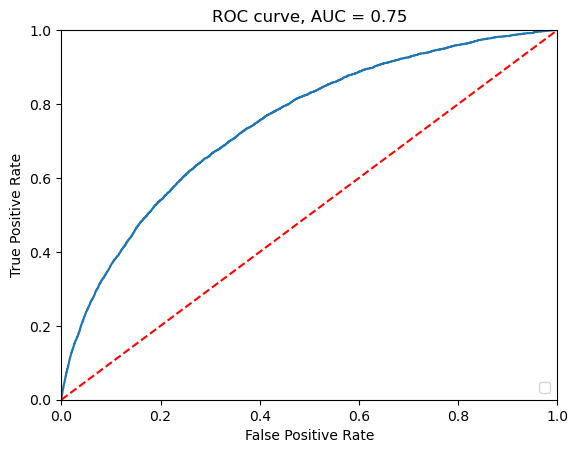

In [71]:
from sklearn.model_selection import GridSearchCV
param = {}
param['learning_rate'] = [0.1,0.3,0.5]
param['n_estimators'] = [20,50,75]
param['max_features'] = ['log2', 'sqrt']

gcv = GridSearchCV(GradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv.fit(X_train, y_train, sample_weight = sample_weights)
print(gcv.best_params_)
find_best_threshold(gcv, X_test, y_test)
plot_roc_curve(gcv, X_test, y_test)

{'learning_rate': 0.2, 'max_features': 'sqrt', 'n_estimators': 150}
Optimization terminated successfully.
         Current function value: 41528.000000
         Iterations: 14
         Function evaluations: 29
For the best threshold 0.5011474609375001, the accuracy score is 0.7040207084043342


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


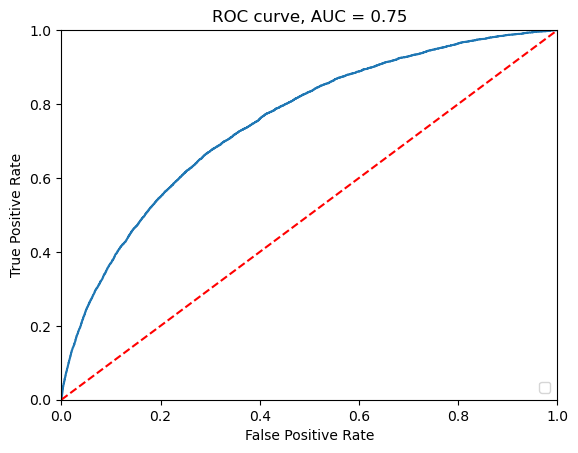

In [72]:
param = {}
param['learning_rate'] = [0.2,0.3,0.4]
param['n_estimators'] = [75,100,150]
param['max_features'] = ['log2','sqrt']

gcv = GridSearchCV(GradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv.fit(X_train, y_train, sample_weight = sample_weights)
print(gcv.best_params_)
find_best_threshold(gcv, X_test, y_test)
plot_roc_curve(gcv, X_test, y_test)

{'learning_rate': 0.275, 'max_features': 'sqrt', 'n_estimators': 250}
Optimization terminated successfully.
         Current function value: 41182.000000
         Iterations: 12
         Function evaluations: 29
For the best threshold 0.525439453125, the accuracy score is 0.7403644783225152


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


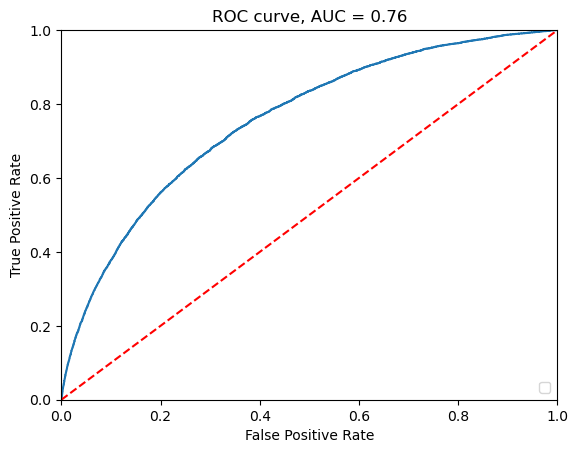

In [73]:
param = {}
param['learning_rate'] = [0.225,0.25,0.275]
param['n_estimators'] = [150,200,250]
param['max_features'] = ['sqrt']

gcv = GridSearchCV(GradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv.fit(X_train, y_train, sample_weight = sample_weights)
print(gcv.best_params_)
find_best_threshold(gcv, X_test, y_test)
plot_roc_curve(gcv, X_test, y_test)

In [75]:
gcv.cv_results_

{'mean_fit_time': array([51.7040031 , 68.54455104, 85.8772469 , 52.3400094 , 69.6325315 ,
        85.18831964, 52.5490418 , 68.76889534, 84.51757021]),
 'std_fit_time': array([0.45547443, 0.8142128 , 1.18463488, 0.41362751, 0.75616515,
        1.1273793 , 0.68456123, 0.7222155 , 1.0420347 ]),
 'mean_score_time': array([0.52470326, 0.60677772, 0.69846749, 0.51850166, 0.59316812,
        0.69927258, 0.51649494, 0.58936415, 0.67524896]),
 'std_score_time': array([0.01141134, 0.01169918, 0.01989384, 0.01151819, 0.00734007,
        0.01916487, 0.01925551, 0.01213782, 0.01721762]),
 'param_learning_rate': masked_array(data=[0.225, 0.225, 0.225, 0.25, 0.25, 0.25, 0.275, 0.275,
                    0.275],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt',
                    'sqrt', 'sqrt'],
  